# Post-Training Quantization and Weights Compression of DeepFloyd IF model with NNCF

The goal of this tutorial is to demonstrate how to speed up the model by applying 8-bit post-training quantization and weights compression from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer optimized model via OpenVINO™ Toolkit.

> **NOTE**: you should run [238-deep-floyd-if-convert](238-deep-floyd-if-convert.ipynb) notebook first to generate OpenVINO IR model that is used for optimization.

The optimization process contains the following steps:
1. Compress weights of the converted OpenVINO text encoder from [notebook](238-deep-floyd-if-convert.ipynb) with NNCF.
2. Quantize the converted stage_1 and stage_2 U-Nets from [notebook](238-deep-floyd-if-convert.ipynb) with NNCF.
2. Check the model result using the same input data from the [notebook](238-deep-floyd-if-convert.ipynb).
3. Compare model size of converted and optimized models.
4. Compare performance of converted and optimized models.


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Compress weights](#Compress-weights)
- [Quantize](#Quantize)
    - [Prepare dataset](#Prepare-dataset)
    - [Quantize first stage U-Net](#Quantize-first-stage-U-Net)
    - [Quantize second stage U-Net](#Quantize-second-stage-U-Net)
- [Run optimized OpenVINO model](#Run-optimized-OpenVINO-model)
    - [Compare file sizes](#Compare-file-sizes)
    - [Compare performance time of the converted and optimized models](#Compare-performance-time-of-the-converted-and-optimized-models)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q datasets "nncf>=2.6.0"

In [2]:
import nncf
import torch
import openvino as ov

from diffusers import DiffusionPipeline
from diffusers.utils.pil_utils import pt_to_pil
from pathlib import Path
from typing import Any, List

from utils import TextEncoder, UnetFirstStage, UnetSecondStage

checkpoint_variant = 'fp16'
model_dtype = torch.float32
RANDOM_SEED = 42
N_DIFFUSION_STEPS = 50
UNET_2_STEPS = 20

core = ov.Core()

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [3]:
MODEL_DIR = Path('./models')
TEXT_ENCODER_IR_PATH = MODEL_DIR / "encoder_ir.xml"
UNET_I_IR_PATH = MODEL_DIR / "unet_ir_I.xml"
UNET_II_IR_PATH = MODEL_DIR / "unet_ir_II.xml"

if not (TEXT_ENCODER_IR_PATH.exists() and UNET_I_IR_PATH.exists() and UNET_II_IR_PATH.exists()):
    raise RuntimeError('This notebook should be run after 238-deep-floyd-if notebook')

In [4]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

## Compress weights
[back to top ⬆️](#Table-of-contents:)

Text encoder model consumes ~22 GB of disk space. To avoid running out of memory, we suggest using 8-bit weights compression instead of quantization. An optimized model will show less speed up than a quantized model, but this will significantly reduce the model footprint.

In [5]:
%%time

text_encoder = core.read_model(TEXT_ENCODER_IR_PATH)
text_encoder_optimized = nncf.compress_weights(text_encoder)

TEXT_ENCODER_INT8_IR_PATH = Path("_optimized.".join(TEXT_ENCODER_IR_PATH.as_posix().split(".")))
ov.save_model(text_encoder_optimized, TEXT_ENCODER_INT8_IR_PATH)

2023-10-30 08:36:34.384792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 08:36:34.423283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 08:36:35.184200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


CPU times: user 3min 16s, sys: 58 s, total: 4min 14s
Wall time: 4min 12s


## Quantize
[back to top ⬆️](#Table-of-contents:)


### Prepare dataset
[back to top ⬆️](#Table-of-contents:)

DeepFloyd IF consists of a U-Net model for first and second stages.
First stage U-Net generates 64x64 px image based on text prompt, second stage U-Net generates a 256x256 px image based on image from previous step.
We use a portion of train [LAION2B](https://huggingface.co/datasets/laion/laion2B-en-aesthetic) dataset from Hugging Face as calibration data.
LAION2B is the English subset of the [LAION5B](https://laion.ai/blog/laion-5b/) dataset, contains over 2 billion objects.

In [6]:
import numpy as np
from datasets import load_dataset

np.random.seed(RANDOM_SEED)

def get_negative_prompt():
    negative_prompts = [
        "amateur", "blurred", "deformed", "disfigured", "disgusting", "jpeg artifacts", "low contrast",
        "low quality", "low saturation", "mangled", "morbid", "mutilated", "mutation",
        "out of frame", "out of frame", "ugly", "uncentered", "underexposed", "unreal",
    ]
    num_elements = np.random.randint(2, 6)
    random_elements = np.random.choice(negative_prompts, num_elements)
    return [" ".join(random_elements)]

def prepare_calibration_data(dataloader, stage_1):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    for batch in dataloader:
        prompt = batch["TEXT"]
        negative_prompt = get_negative_prompt()
        prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, negative_prompt=negative_prompt)
        data.append((prompt_embeds, negative_embeds))
    return data


def prepare_dataset(stage_1, opt_init_steps=300):
    """
    Prepares a text dataset for quantization.
    """
    dataset = load_dataset("laion/laion2B-en-aesthetic", streaming=True, split="train")
    train_dataset = dataset.shuffle(seed=RANDOM_SEED, buffer_size=1000).take(opt_init_steps)
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    calibration_data = prepare_calibration_data(dataloader, stage_1)
    return calibration_data

In [7]:
%%time

generator = torch.manual_seed(RANDOM_SEED)
opt_init_steps = 300
selection_prob = 0.5
prompts_number = np.ceil(opt_init_steps // (min(N_DIFFUSION_STEPS, UNET_2_STEPS) * selection_prob))

stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-M-v1.0",
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)
encoded_prompts = prepare_dataset(stage_1, int(prompts_number))

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin, text_encoder/pytorch_model.fp16-00002-of-00002.bin]
Loaded non-fp16 filenames:
[safety_checker/pytorch_model.bin, watermarker/diffusion_pytorch_model.bin
If this behavior is not expected, please check your folder structure.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/ea/work/ov_venv/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCo

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 18min 16s, sys: 1min 2s, total: 19min 18s
Wall time: 2min 5s


To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [8]:
class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float, data_cache: List[Any] = []):
        super().__init__(compiled_model)
        self.data_cache = data_cache
        self.prob = np.clip(prob, 0, 1)

    def __call__(self, *args, **kwargs):
        if np.random.rand() >= self.prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

In [9]:
stage_1.unet = UnetFirstStage(
    UNET_I_IR_PATH,
    stage_1.unet.config,
    dtype=model_dtype,
    device=device.value
)
stage_1.set_progress_bar_config(disable=True)

stage_1_data_cache = []
stage_1.unet.unet_openvino = CompiledModelDecorator(stage_1.unet.unet_openvino, prob=selection_prob, data_cache=stage_1_data_cache)

generator = torch.manual_seed(RANDOM_SEED)
stage_2_inputs = []  # to speed up dataset preparation for stage 2 U-Net we can collect several images below
for data in encoded_prompts:
    prompt_embeds, negative_embeds = data
    image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                    generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images
    stage_2_inputs.append((image, prompt_embeds, negative_embeds))

    if len(stage_1_data_cache) >= opt_init_steps:
        break

### Quantize first stage U-Net
[back to top ⬆️](#Table-of-contents:)


In [10]:
%%time

ov_model = core.read_model(UNET_I_IR_PATH)
stage_1_calibration_dataset = nncf.Dataset(stage_1_data_cache, lambda x: x)

quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=stage_1_calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
    advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alpha=0.25)
)

UNET_I_INT8_PATH = "_optimized.".join(UNET_I_IR_PATH.as_posix().split("."))
ov.save_model(quantized_model, UNET_I_INT8_PATH)

Applying Fast Bias correction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:35<00:00,  7.50it/s]


CPU times: user 1h 8min 46s, sys: 1min 22s, total: 1h 10min 8s
Wall time: 9min 46s


In [11]:
%%time

from tqdm.notebook import tqdm

start = len(stage_2_inputs)
for i, data in tqdm(enumerate(encoded_prompts[start:])):
    prompt_embeds, negative_embeds = data
    image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                    generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images
    stage_2_inputs.append((image, prompt_embeds, negative_embeds))

0it [00:00, ?it/s]

CPU times: user 1h 17min 46s, sys: 44.9 s, total: 1h 18min 31s
Wall time: 4min 46s


In [12]:
%%time

generator = torch.manual_seed(RANDOM_SEED)
opt_init_steps = 300

stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-M-v1.0",
    text_encoder=None,
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)
stage_2.set_progress_bar_config(disable=True)

stage_2.unet = UnetSecondStage(
    UNET_II_IR_PATH,
    stage_2.unet.config,
    dtype=model_dtype,
    device=device.value
)
stage_2_data_cache = []
stage_2.unet.unet_openvino = CompiledModelDecorator(stage_2.unet.unet_openvino, prob=selection_prob, data_cache=stage_2_data_cache)

for data in tqdm(stage_2_inputs):
    image, prompt_embeds, negative_embeds = data
    image = stage_2(image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                    generator=generator, output_type="pt", num_inference_steps=UNET_2_STEPS).images

    if len(stage_2_data_cache) >= opt_init_steps:
        break


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 6h 28min 3s, sys: 2min 11s, total: 6h 30min 15s
Wall time: 24min 32s


### Quantize second stage U-Net
[back to top ⬆️](#Table-of-contents:)


In [13]:
%%time

ov_model = core.read_model(UNET_II_IR_PATH)

calibration_dataset = nncf.Dataset(stage_2_data_cache, lambda x: x)
quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
)

UNET_II_INT8_PATH = "_optimized.".join(UNET_II_IR_PATH.as_posix().split("."))
ov.save_model(quantized_model, UNET_II_INT8_PATH)

Applying Fast Bias correction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:39<00:00,  6.17it/s]


CPU times: user 7h 57min 5s, sys: 6min 43s, total: 8h 3min 49s
Wall time: 49min 24s


## Run optimized OpenVINO model
[back to top ⬆️](#Table-of-contents:)

Let us check predictions with the optimized OpenVINO DeepFloyd IF model result using the same input data from the [1st notebook](238-deep-floyd-if.ipynb).

In [14]:
prompt = 'ultra close color photo portrait of rainbow owl with deer horns in the woods'
negative_prompt = 'blurred unreal uncentered occluded'

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin, text_encoder/pytorch_model.fp16-00002-of-00002.bin]
Loaded non-fp16 filenames:
[safety_checker/pytorch_model.bin, watermarker/diffusion_pytorch_model.bin
If this behavior is not expected, please check your folder structure.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The model has been loaded


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 3min 39s, sys: 21 s, total: 4min
Wall time: 58.7 s


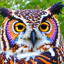

In [15]:
%%time

stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-M-v1.0",
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)

# Initialize the First Stage U-Net wrapper class
stage_1.unet = UnetFirstStage(
    UNET_I_INT8_PATH,
    stage_1.unet.config,
    dtype=model_dtype,
    device=device.value
)

stage_1.text_encoder = TextEncoder(TEXT_ENCODER_INT8_IR_PATH, dtype=model_dtype, device=device.value)
print('The model has been loaded')

# Generate text embeddings
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, negative_prompt=negative_prompt)

# Fix PRNG seed
generator = torch.manual_seed(RANDOM_SEED)

# Inference
image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images

# Show the image
pt_to_pil(image)[0]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The model has been loaded


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 6min 20s, sys: 6.78 s, total: 6min 27s
Wall time: 32.1 s


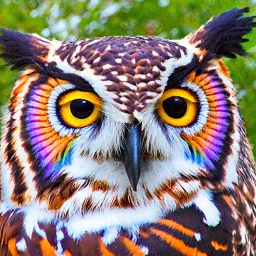

In [16]:
%%time

stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-M-v1.0",
    text_encoder=None,
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)

# Initialize the Second Stage U-Net wrapper class
stage_2.unet = UnetSecondStage(
    UNET_II_INT8_PATH,
    stage_2.unet.config,
    dtype=model_dtype,
    device=device.value
)
print('The model has been loaded')

image = stage_2(
    image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
    generator=generator, output_type="pt", num_inference_steps=UNET_2_STEPS).images

# Show the image
pil_image = pt_to_pil(image)[0]
pil_image

single-image-super-resolution-1032 already downloaded to models


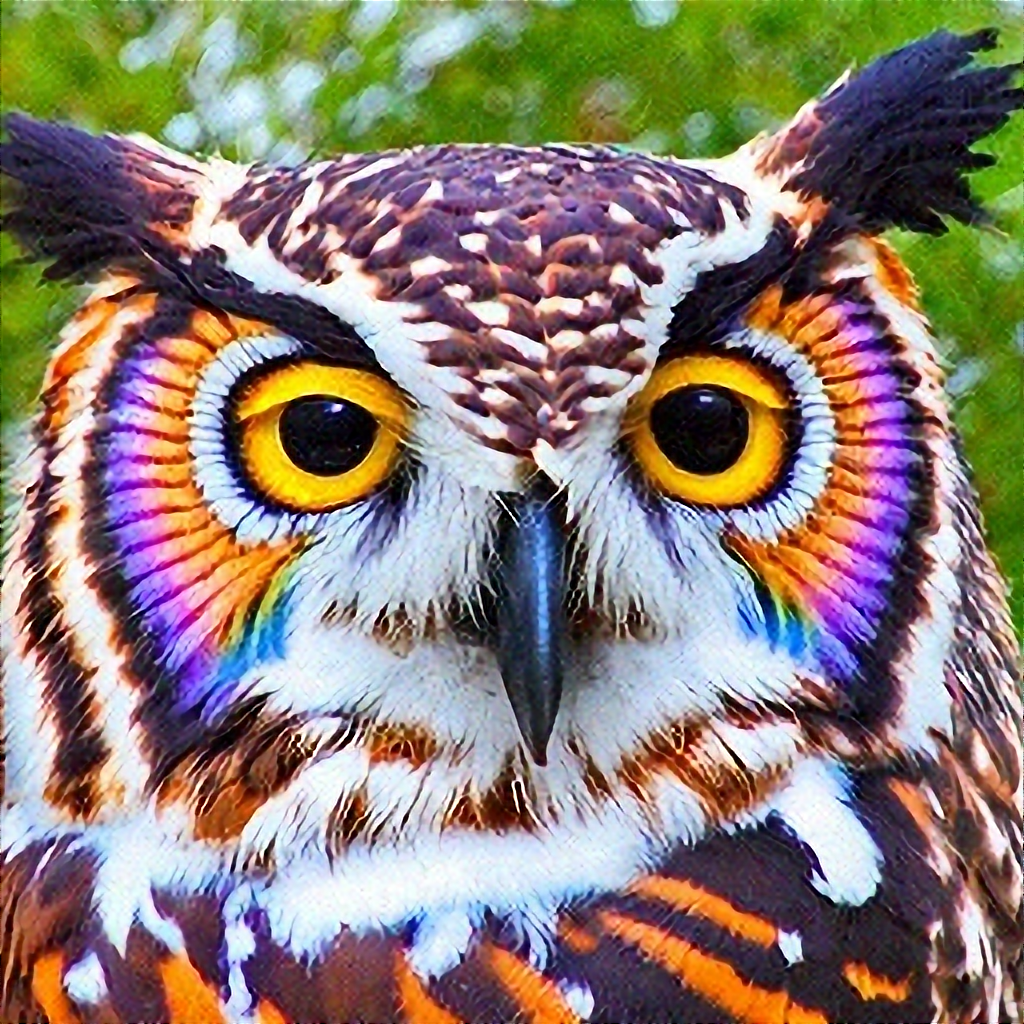

In [17]:

import cv2
import numpy as np
from utils import convert_result_to_image, download_omz_model

# 1032: 4x superresolution, 1033: 3x superresolution
model_name = 'single-image-super-resolution-1032'
download_omz_model(model_name, MODEL_DIR)

sr_model_xml_path = MODEL_DIR / f'{model_name}.xml'
model = core.read_model(model=sr_model_xml_path)
model.reshape({
    0: [1, 3, 256, 256],
    1: [1, 3, 1024, 1024]
})
compiled_sr_model = core.compile_model(model=model, device_name=device.value)

original_image = np.array(pil_image)
bicubic_image = cv2.resize(
    src=original_image, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC
)

# Reshape the images from (H,W,C) to (N,C,H,W) as expected by the model.
input_image_original = np.expand_dims(original_image.transpose(2, 0, 1), axis=0)
input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

# Model Inference
result = compiled_sr_model(
    [input_image_original, input_image_bicubic]
)[compiled_sr_model.output(0)]

img = convert_result_to_image(result)
img

> **NOTE**: Accuracy of quantized models can generally be improved by increasing calibration dataset size. For U-Net models, you can collect a more diverse dataset by using a smaller `selection_prob` value, but this will increase the dataset collection time.

#### Compare file sizes
[back to top ⬆️](#Table-of-contents:)

Let's calculate the compression rate of the optimized IRs file size relative to the FP16 OpenVINO models file size

In [18]:
def calculate_compression_rate(ov_model_path):
    fp16_ir_model_size = Path(ov_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
    int8_model_path = "_optimized.".join(ov_model_path.as_posix().split("."))
    quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
    print(f'{ov_model_path.as_posix().split(".")[0]}')
    print(f"    * FP16 IR model size: {fp16_ir_model_size:.2f} MB")
    print(f"    * INT8 model size: {quantized_model_size:.2f} MB")
    print(f"    * Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

In [19]:
for model_path in [TEXT_ENCODER_IR_PATH, UNET_I_IR_PATH, UNET_II_IR_PATH]:
    calculate_compression_rate(model_path)

models/encoder_ir
    * FP16 IR model size: 22006.77 MB
    * INT8 model size: 4546.70 MB
    * Model compression rate: 4.840
models/unet_ir_I
    * FP16 IR model size: 1417.56 MB
    * INT8 model size: 355.16 MB
    * Model compression rate: 3.991
models/unet_ir_II
    * FP16 IR model size: 1758.82 MB
    * INT8 model size: 440.49 MB
    * Model compression rate: 3.993


#### Compare performance time of the converted and optimized models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of OpenVINO FP16 and INT8 models, use [Benchmark Tool](https://docs.openvino.ai/2023.3/openvino_sample_benchmark_tool.html).

> **NOTE**: For more accurate performance, run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app --help` to see an overview of all command-line options.

In [20]:
import re

def get_fps(benchmark_output: str):
    parsed_output = [line for line in benchmark_output if 'Throughput:' in line]
    fps = re.findall(r"\d+\.\d+", parsed_output[0])[0]
    return fps

Text encoder

In [21]:
benchmark_output = !benchmark_app -m $TEXT_ENCODER_IR_PATH -d $device.value -api async
original_fps = get_fps(benchmark_output)
print(f"FP16 Text Encoder Throughput: {original_fps} FPS")

benchmark_output = !benchmark_app -m $TEXT_ENCODER_INT8_IR_PATH -d $device.value -api async
optimized_fps = get_fps(benchmark_output)
print(f"INT8 Text Encoder Throughput: {optimized_fps} FPS")
print(f"Text encoder speed up: {float(optimized_fps) / float(original_fps)}")

FP16 Text Encoder Throughput: 0.99 FPS
INT8 Text Encoder Throughput: 2.47 FPS
Text encoder speed up: 2.4949494949494953


First stage UNet

In [22]:
benchmark_output = !benchmark_app -m $UNET_I_IR_PATH -d $device.value -api async
original_fps = get_fps(benchmark_output)
print(f"FP16 1 stage U-Net Throughput: {original_fps} FPS")

benchmark_output = !benchmark_app -m $UNET_I_INT8_PATH -d $device.value -api async
optimized_fps = get_fps(benchmark_output)
print(f"INT8 1 stage U-Net Throughput: {optimized_fps} FPS")
print(f"1 stage U-Net speed up: {float(optimized_fps) / float(original_fps)}")

FP16 1 stage U-Net Throughput: 4.65 FPS
INT8 1 stage U-Net Throughput: 12.06 FPS
1 stage U-Net speed up: 2.593548387096774


Second stage UNet

In [23]:
benchmark_output = !benchmark_app -m $UNET_II_IR_PATH -d $device.value -api async
original_fps = get_fps(benchmark_output)
print(f"FP16 2 stage U-Net Throughput: {original_fps} FPS")

benchmark_output = !benchmark_app -m $UNET_II_INT8_PATH -d $device.value -api async
optimized_fps = get_fps(benchmark_output)
print(f"INT8 2 stage U-Net Throughput: {optimized_fps} FPS")
print(f"2 stage U-Net speed up: {float(optimized_fps) / float(original_fps)}")

FP16 2 stage U-Net Throughput: 0.28 FPS
INT8 2 stage U-Net Throughput: 0.92 FPS
2 stage U-Net speed up: 3.2857142857142856
